# Overview

This notebook demonstrates how to scan for TF binding motifs. The base GRN will be generated by combining the ATAC-seq peaks and motif information.

### Notebook file
Notebook file is available on CellOracle's GitHub page.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/02_motif_scan/02_atac_peaks_to_TFinfo_with_celloracle_20200801.ipynb


# 0. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns

import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [2]:
import celloracle as co
from celloracle import motif_analysis as ma
from celloracle.utility import save_as_pickled_object
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams["savefig.dpi"] = 600

In [5]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[6,6])
    plt.rc('svg', fonttype='none')
    
set_plotting_style()

# 1. Rerefence genome data preparation
## 1.1. Check reference genome installation

Before starting the analysis, we need to make sure the reference genome data is installed. If not, please install the correct reference genome using the instructions below.


In [6]:
ma.SUPPORTED_REF_GENOME

,species,ref_genome,provider
0,Human,hg38,UCSC
1,Human,hg19,UCSC
2,Mouse,mm39,UCSC
3,Mouse,mm10,UCSC
4,Mouse,mm9,UCSC
5,S.cerevisiae,sacCer2,UCSC
6,S.cerevisiae,sacCer3,UCSC
7,Zebrafish,danRer7,UCSC
8,Zebrafish,danRer10,UCSC
9,Zebrafish,danRer11,UCSC


In [8]:
# # PLEASE make sure reference genome is correct.
# ref_genome = "danRer11"

# genome_installation = ma.is_genome_installed(ref_genome=ref_genome)
# print(ref_genome, "installation: ", genome_installation)

In [6]:
# import genomepy
# genomepy.install_genome(name="danRer11", provider="UCSC")

21:35:20 | INFO | Downloading assembly summaries from UCSC
21:35:20 | INFO | Downloading genome from UCSC. Target URL: https://hgdownload.soe.ucsc.edu/goldenPath/danRer11/bigZips/danRer11.fa.gz...


Download:   0%|          | 0.00/518M [00:00<?, ?B/s]

21:35:26 | INFO | Genome download successful, starting post processing...
21:35:35 | INFO | name: danRer11
21:35:35 | INFO | local name: danRer11
21:35:35 | INFO | fasta: /home/yang-joon.kim/.local/share/genomes/danRer11/danRer11.fa


Filtering Fasta: 0.00 lines [00:00, ? lines/s]

Fasta("/home/yang-joon.kim/.local/share/genomes/danRer11/danRer11.fa")

## 1.2. Install reference genome (if refgenome is not installed)

Before installing the reference genome, please check the refenome is in the celloracle supported reference genome list. 
You can check supported reference genome using `ma.SUPPORTED_REF_GENOME`

If your reference genome is not in the list, please send a request to us through CellOracle GitHub issue page.

In [17]:
ma.SUPPORTED_REF_GENOME

,species,ref_genome,provider
0,Human,hg38,UCSC
1,Human,hg19,UCSC
2,Mouse,mm39,UCSC
3,Mouse,mm10,UCSC
4,Mouse,mm9,UCSC
5,S.cerevisiae,sacCer2,UCSC
6,S.cerevisiae,sacCer3,UCSC
7,Zebrafish,danRer7,UCSC
8,Zebrafish,danRer10,UCSC
9,Zebrafish,danRer11,UCSC


# 2. Load data


## 2.0. Input data format

In this notebook, we explain how to make a base GRN.

Please look at the previous steps for details on preprocessing data for a base GRN

https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html#step1-scatac-seq-analysis-with-cicero



The scATAC-seq file needs to be converted in a csv file three columns:
- The first column is index.
- The second column is peak_id.
- The third column is gene_short_name.


A correctly formatted file will look like this:



<img src="https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/processed_peak_csv.png">


We will load the .csv file as a `pandas.DataFrame` using pd.read_csv().


<img src="https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/processed_peak_df.png">




## 2.0. Download demo data

You can download the demo file by running the following command.

Note: If the file download fails, please manually download and unzip the data.

https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/processed_peak_file.csv


In [6]:
# # Download file. 
# !wget https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/processed_peak_file.csv
    
# # If you are using macOS, please try the following command.
# #!curl -O https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/processed_peak_file.csv


--2022-05-07 18:00:42--  https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/processed_peak_file.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569448 (556K) [text/plain]
Saving to: ‘processed_peak_file.csv’

processed_peak_file 100%[===================>] 556.10K  --.-KB/s    in 0.008s  

2022-05-07 18:00:43 (67.9 MB/s) - ‘processed_peak_file.csv’ saved [569448/569448]



## 2.1. Load processed peak data 

In [10]:
cicero_output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/"

# Load annotated peak data.
peaks = pd.read_csv(cicero_output_path + "03_TDR118_processed_peak_file_danRer11.csv", index_col=0)
peaks.head()

,peak_id,gene_short_name
0,chr10_10310135_10311044,mir219-1
1,chr10_10312654_10313520,urm1
2,chr10_10318857_10319768,mir219-1
3,chr10_10330150_10331040,mir219-1
4,chr10_10728430_10729439,swi5


In [19]:
len(peaks)

14511

In [20]:
peaks.gene_short_name.value_counts()

gene_short_name
myf5            10
her1             8
mir196a-1        8
tbx16            7
hoxb3a           7
                ..
ankib1a          1
gatad1           1
LOC100500933     1
lrrc14b          1
ugt1a6           1
Name: count, Length: 12674, dtype: int64

### NOTE.

- processed_peak_file.csv contains only the peaks that satisfy the following conditions:
    - first, these peaks were mapped to the nearest TSS (Transcription Start Sites), then were assigned a gene name.
    - second, the co-accessibility score between the peak and the TSS(peak) should be equal or larger than 0.8 
    

## 2.1. Check data

In [21]:
def decompose_chrstr(peak_str):
    """
    Args:
        peak_str (str): peak_str. e.g. 'chr1_3094484_3095479'
        
    Returns:
        tuple: chromosome name, start position, end position
    """
    
    *chr_, start, end = peak_str.split("_")
    chr_ = "_".join(chr_)
    return chr_, start, end

from genomepy import Genome

def check_peak_format(peaks_df, ref_genome):
    """
    Check peak format. 
     (1) Check chromosome name. 
     (2) Check peak size (length) and remove sort DNA sequences (<5bp)
    
    """
    
    df = peaks_df.copy()
    
    n_peaks_before = df.shape[0]
    
    # Decompose peaks and make df
    decomposed = [decompose_chrstr(peak_str) for peak_str in df["peak_id"]]
    df_decomposed = pd.DataFrame(np.array(decomposed), index=peaks_df.index)
    df_decomposed.columns = ["chr", "start", "end"]
    df_decomposed["start"] = df_decomposed["start"].astype(int)
    df_decomposed["end"] = df_decomposed["end"].astype(int)
    
    # Load genome data
    genome_data = Genome(ref_genome)
    all_chr_list = list(genome_data.keys())
    
    
    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])
    
    
    # Filter peaks with invalid chromosome name
    n_threshold = 5
    df = df[(lengths >= n_threshold) & df_decomposed.chr.isin(all_chr_list)]
    
    # DNA length check
    lengths = np.abs(df_decomposed["end"] - df_decomposed["start"])
    
    # Data counting
    n_invalid_length = len(lengths[lengths < n_threshold])
    n_peaks_invalid_chr = n_peaks_before - df_decomposed.chr.isin(all_chr_list).sum()
    n_peaks_after = df.shape[0]
    
    
    #
    print("Peaks before filtering: ", n_peaks_before)
    print("Peaks with invalid chr_name: ", n_peaks_invalid_chr)
    print("Peaks with invalid length: ", n_invalid_length)
    print("Peaks after filtering: ", n_peaks_after)
    
    return df



In [22]:
peaks = check_peak_format(peaks, ref_genome)

Peaks before filtering:  14511
Peaks with invalid chr_name:  0
Peaks with invalid length:  0
Peaks after filtering:  14511


## 2.2. [Optional step] Load custom motifs

You can choose to use either a custom TF binding reference or CellOracle’s default motifs during the motif analysis. If you would like to use our default motifs, you can continue to the next step without loading any additional data.


If you would like to use a custom motif dataset, please choose one of the following options.

- Motifs provided by gimmemotifs
 >Gimmemotifs is a python package for motif analysis. It provides many motif dataset. https://gimmemotifs.readthedocs.io/en/master/overview.html#motif-databases
 > 
 > Please use this notebook to learn how to load motif data from gimmemotifs database. 
 > https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/02_motif_scan/motif_data_preparation/01_How_to_load_gimmemotifs_motif_data.ipynb

- Custom motifs provided by CellOracle.
 
 >CellOracle also provides many motif datasets generated from CisBP. http://cisbp.ccbr.utoronto.ca/
 >
 >Please look at this notebook to learn how to load the CisBP motifs.https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/02_motif_scan/motif_data_preparation/02_How_to_load_CisBPv2_motif_data.ipynb


- Make your own custom motif data.
 >You can create custom motif data by yourself.
 >
 >Please look at this notebook to learn how to create your custom motif dataset.https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/02_motif_scan/motif_data_preparation/03_How_to_make_custom_motif.ipynb


# 3. Instantiate TFinfo object and search for TF binding motifs
The motif analysis module has a custom class, `TFinfo`. 
The TFinfo object executes the steps below.

- Converts a peak data into sequences of DNA elements.
- Scans the DNA sequences searching for TF binding motifs.
- Post-processes the motif scan results.
- Converts data into appropriate format. You can convert data into base-GRN. The base GRN data can be formatted as either a python dictionary or pandas dataframe. This output will be the final base GRN used in the GRN model construction step.

## 3.1. Instantiate TFinfo object

<AxesSubplot:xlabel='count', ylabel='Count'>

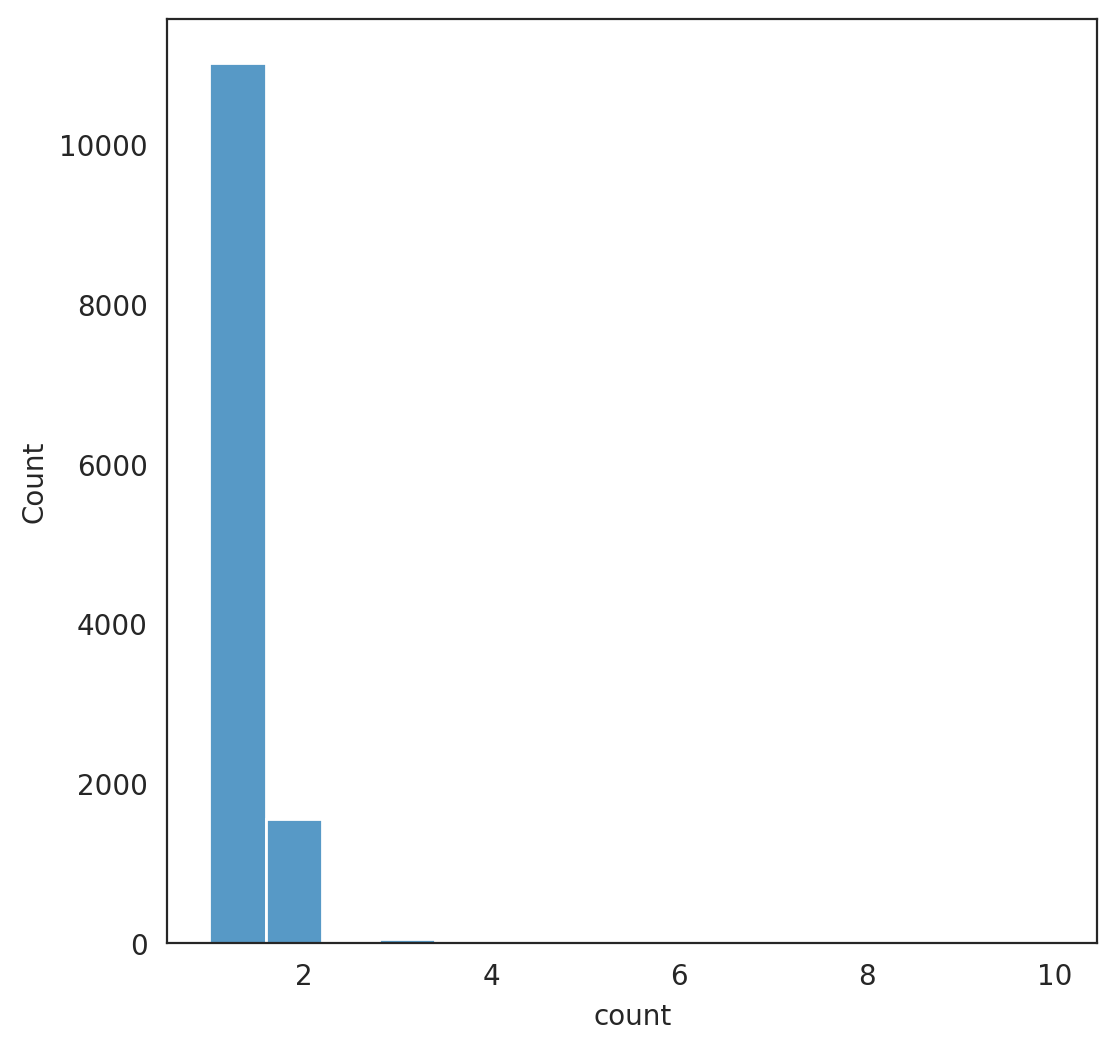

In [108]:
sns.histplot(peaks.gene_short_name.value_counts())

In [13]:
ref_genome

'danRer11'

In [24]:
# Instantiate TFinfo object
tfi = ma.TFinfo(peak_data_frame=peaks, 
                ref_genome=ref_genome) 

## 3.2. Motif scan


You can specify the TF binding motif data as follows. 

`tfi.scan(motifs=motifs)`

If you do not specify the motifs or set motifs to `None`, the default motifs will be loaded automatically.

- For mouse and human, "gimme.vertebrate.v5.0." will be used as the default motifs. 

- For another species, the species-specific TF binding motif data extracted from CisBP ver2.0 will be used.



**If your jupyter notebook kernel is killed during the motif scan process, please see the link below.**

https://morris-lab.github.io/CellOracle.documentation/installation/python_step_by_step_installation.html#install-gimmemotifs-with-conda

In [26]:
%%time
# Scan motifs. !!CAUTION!! This step may take several hours if you have many peaks!
tfi.scan(fpr=0.02, 
         motifs=None,  # If you enter None, default motifs will be loaded.
         verbose=True, n_cpus=-1)

# Save tfinfo object
tfi.to_hdf5(file_path=cicero_output_path + "04_TDR118_peaks_motifs_TFs.celloracle.tfinfo")

No motif data entered. Loading default motifs for your species ...
 Default motif for Zebrafish: CisBP_ver2_Danio_rerio.pfm. 
 For more information about the motif data, please see http://cisbp.ccbr.utoronto.ca. 

Initiating scanner... 



DEBUG:gimme.scanner:using background: genome danRer11 with size 200


Calculating FPR-based threshold. This step may take substantial time when you load a new ref-genome. It will be done quicker on the second time. 

Motif scan started .. It may take long time.



scanning:   0%|          | 0/13936 [00:00<?, ? sequences/s]

DEBUG:gimme.scanner:Scanning


CPU times: user 1h 24min 42s, sys: 52.6 s, total: 1h 25min 34s
Wall time: 1h 26min


In [29]:
# Check motif scan results
tfi.scanned_df.head()

,seqname,motif_id,factors_direct,factors_indirect,score,pos,strand
0,chr10_10310135_10311044,M00126_2.00,,"nrl, mafa, mafk, mafba, mafga, mafb, mafbb, mafgb",9.002696,505,1
1,chr10_10310135_10311044,M00133_2.00,,"FO704755.1, sp3a, sp9, sp5l, sp4, sp8b, sp8a, ...",8.055444,529,-1
2,chr10_10310135_10311044,M00135_2.00,,zbtb7b,7.711621,377,1
3,chr10_10310135_10311044,M00139_2.00,,"znf281a, znf281b, znf148",8.657963,528,-1
4,chr10_10310135_10311044,M00143_2.00,,znf740b,7.104591,527,-1


## Exploratory Data Analysis on the tfi.scanned_df

In [35]:
tfi.scanned_df["seqname"].value_counts()

seqname
chr25_3326547_3327457      1628
chr5_1047106_1047959       1627
chr22_195121_195993        1617
chr5_37087047_37087934     1590
chr1_171543_172374         1539
                           ... 
chr5_4493387_4493856         96
chr3_46379325_46379660       94
chr6_13095987_13096350       83
chr24_7699894_7700148        74
chr17_48946883_48947136      67
Name: count, Length: 13936, dtype: int64

In [37]:
n_motifs_per_peak = tfi.scanned_df["seqname"].value_counts()
n_motifs_per_peak

seqname
chr25_3326547_3327457      1628
chr5_1047106_1047959       1627
chr22_195121_195993        1617
chr5_37087047_37087934     1590
chr1_171543_172374         1539
                           ... 
chr5_4493387_4493856         96
chr3_46379325_46379660       94
chr6_13095987_13096350       83
chr24_7699894_7700148        74
chr17_48946883_48947136      67
Name: count, Length: 13936, dtype: int64

In [41]:
peak = n_motifs_per_peak.index[0]
peak

'chr25_3326547_3327457'

In [51]:
genomic_region = peak.split("_")
genomic_region

peak_length = abs(int(genomic_region[1]) - int(genomic_region[2]))
peak_length

910

In [63]:
df_peaks_motifs = pd.DataFrame({"peak":n_motifs_per_peak.index.to_list(), 
                               "n_motifs":list(n_motifs_per_peak.values)})
df_peaks_motifs

,peak,n_motifs
0,chr25_3326547_3327457,1628
1,chr5_1047106_1047959,1627
2,chr22_195121_195993,1617
3,chr5_37087047_37087934,1590
4,chr1_171543_172374,1539
...,...,...
13931,chr5_4493387_4493856,96
13932,chr3_46379325_46379660,94
13933,chr6_13095987_13096350,83
13934,chr24_7699894_7700148,74


Text(0, 0.5, 'occurences')

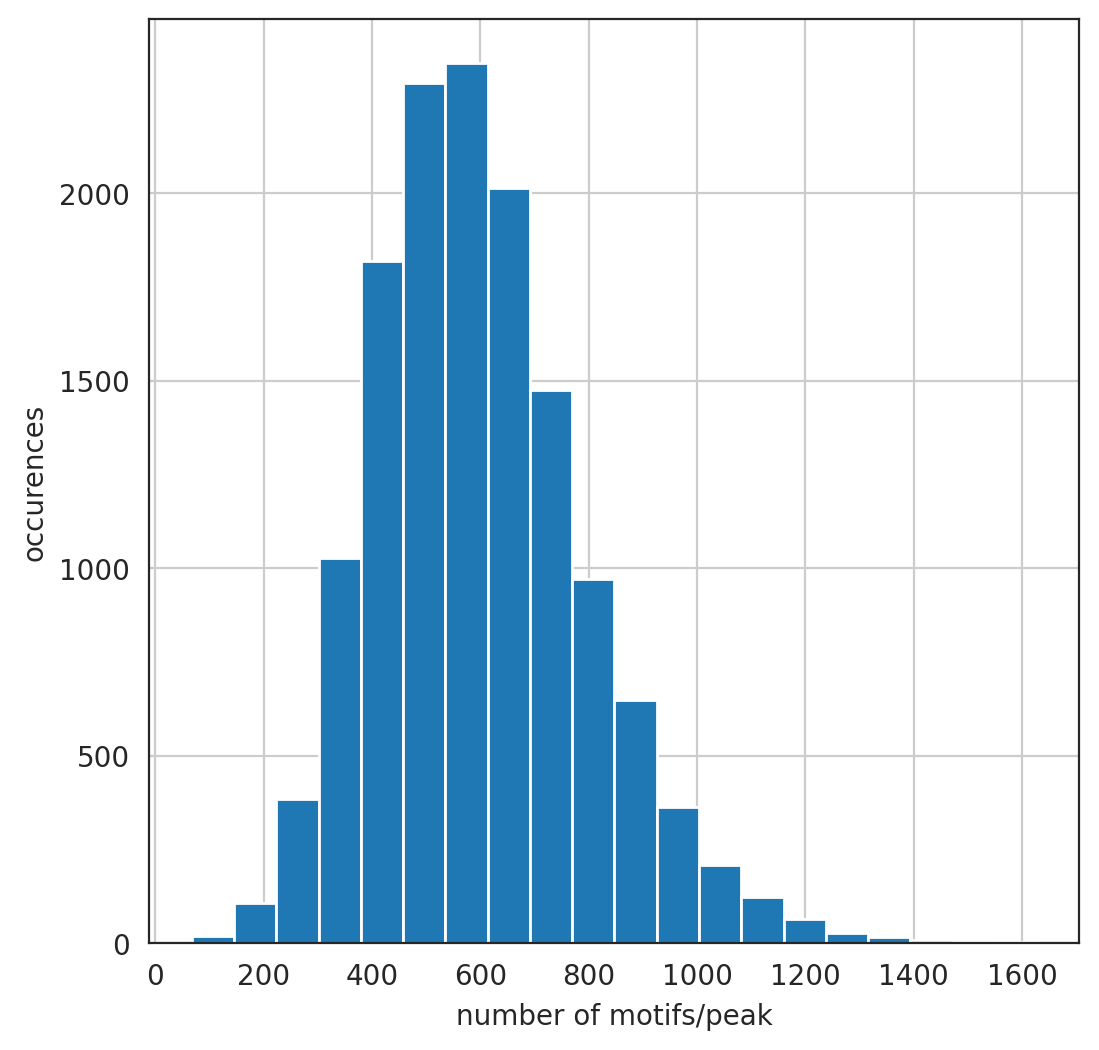

In [109]:
df_peaks_motifs.n_motifs.hist(bins=20)
plt.xlabel("number of motifs/peak")
plt.ylabel("occurences")

In [75]:
ls_sample = [1,2,3]
ls_sample

ls_sample.append(4)
ls_sample

[1, 2, 3, 4]

In [81]:
df_peaks_motifs

peak_lengths = []
chrom = []

for peak in n_motifs_per_peak.index:
    # extract the genomic region
    genomic_region = peak.split("_")
    genomic_region
    
    # compute the peak length
    peak_length = abs(int(genomic_region[1]) - int(genomic_region[2]))
    peak_lengths.append(peak_length)
    
    # add the chromosome number
    chrom.append(genomic_region[0])

df_peaks_motifs["peak_lengths"] = peak_lengths
df_peaks_motifs["chromosome"] = chrom
df_peaks_motifs

,peak,n_motifs,peak_lengths,chromosome
0,chr25_3326547_3327457,1628,910,chr25
1,chr5_1047106_1047959,1627,853,chr5
2,chr22_195121_195993,1617,872,chr22
3,chr5_37087047_37087934,1590,887,chr5
4,chr1_171543_172374,1539,831,chr1
...,...,...,...,...
13931,chr5_4493387_4493856,96,469,chr5
13932,chr3_46379325_46379660,94,335,chr3
13933,chr6_13095987_13096350,83,363,chr6
13934,chr24_7699894_7700148,74,254,chr24


In [99]:
chrom_array = df_peaks_motifs["chromosome"].unique()
chrom_array

sorted_indices

array([ 0,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  1, 19, 20, 21, 22, 23,
       24,  2,  3,  4,  5,  6,  7,  8])

In [95]:
chrom_array = df_peaks_motifs["chromosome"].unique()

sorted_indices = np.argsort(natsorted(chrom_array))

chrom_array_sorted = chrom_array[sorted_indices]
chrom_array_sorted

array(['chr25', 'chr9', 'chr19', 'chr20', 'chr18', 'chr23', 'chr7',
       'chr12', 'chr8', 'chr15', 'chr2', 'chr5', 'chr14', 'chr10',
       'chr11', 'chr3', 'chr17', 'chr13', 'chr22', 'chr1', 'chr21',
       'chr24', 'chr16', 'chr6', 'chr4'], dtype=object)

In [93]:
from natsort import natsorted


Text(0, 0.5, 'number of motifs')

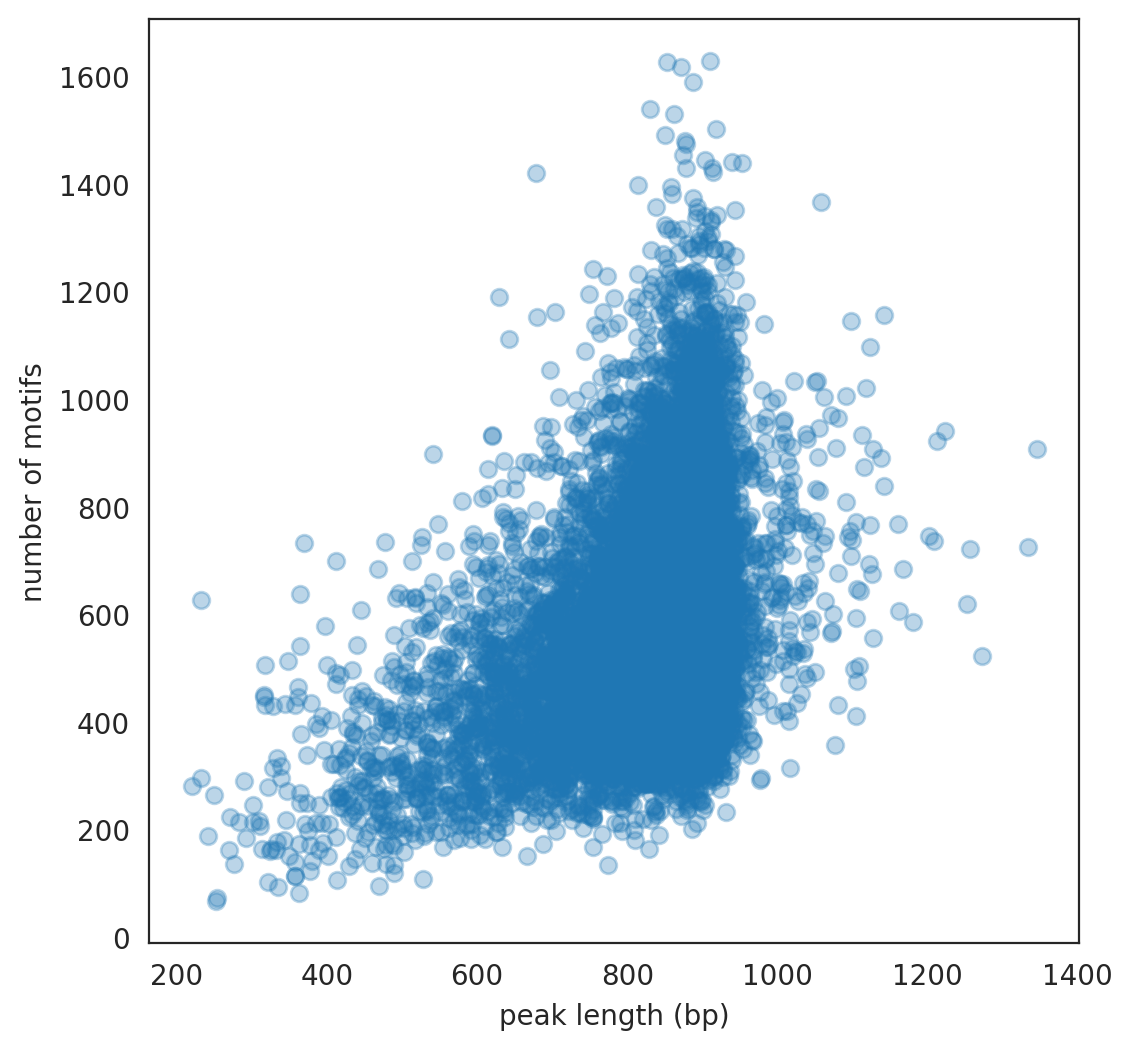

In [112]:
plt.scatter(data = df_peaks_motifs, 
                x="peak_lengths", 
                y="n_motifs", alpha=0.3, )
plt.xlabel("peak length (bp)")
plt.ylabel("number of motifs")

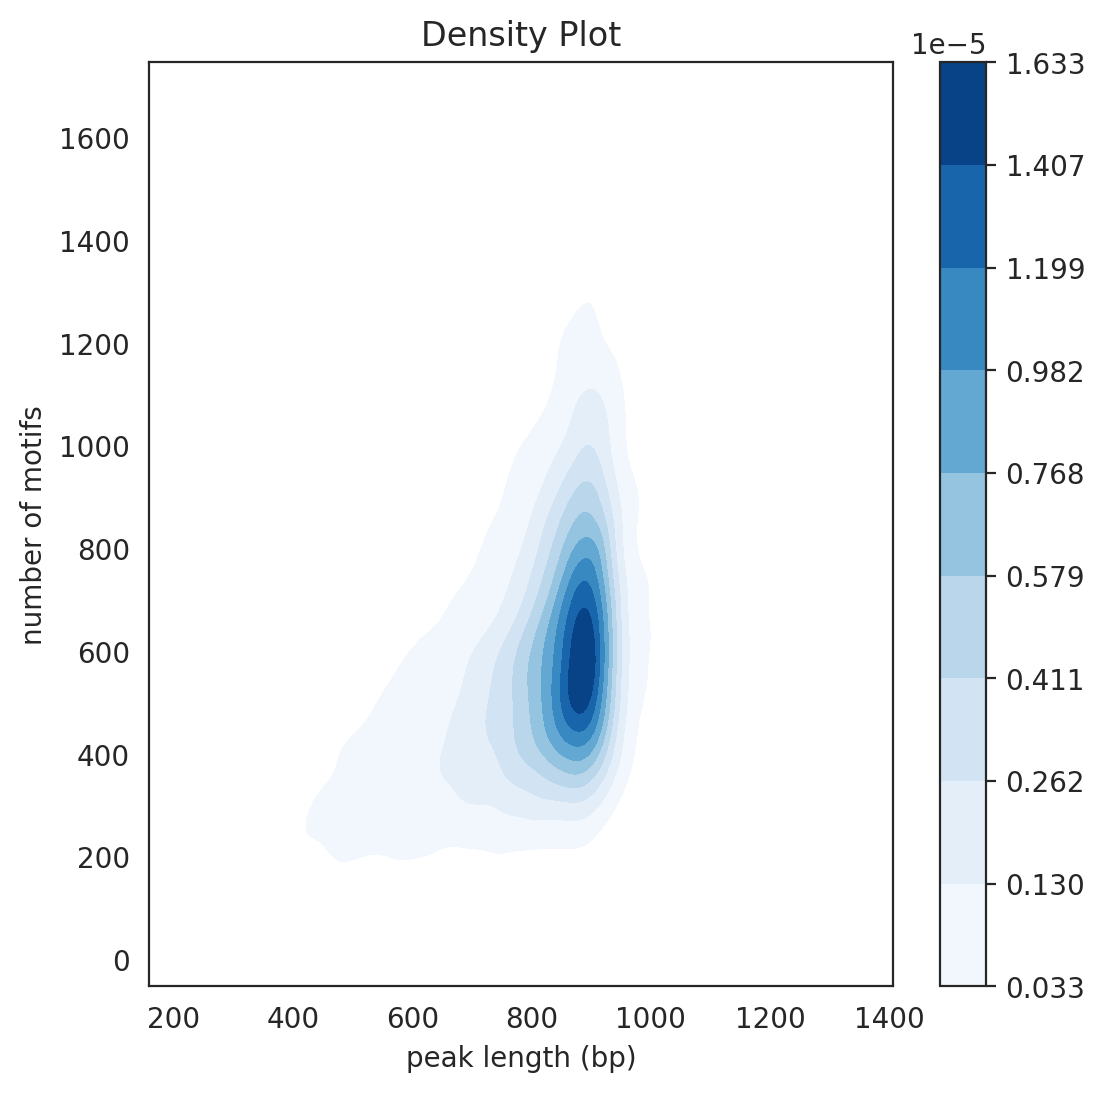

In [113]:
sns.kdeplot(data=df_peaks_motifs, x="peak_lengths", y="n_motifs", cmap="Blues", fill=True, cbar=True)

plt.xlabel("peak length (bp)")
plt.ylabel("number of motifs")
plt.title("Density Plot")
plt.show()

In [118]:
chrom_order = np.array(['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19' 'chr20' 'chr21' 'chr22' 'chr23' 'chr24' 'chr25'])
chrom_order

array(['chr1chr2chr3chr4chr5chr6chr7chr8chr9chr10chr11chr12chr13chr14chr15chr16chr17chr18chr19chr20chr21chr22chr23chr24chr25'],
      dtype='<U116')

In [92]:
chrom_order = np.array['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18' 'chr19' 'chr20' 'chr21' 'chr22' 'chr23' 'chr24' 'chr25']

sns.scatterplot(data = df_peaks_motifs, 
                x="peak_lengths", 
                y="n_motifs", hue = "chromosome", hue_order=chrom_order)

TypeError: 'builtin_function_or_method' object is not subscriptable

In [36]:
tfi.scanned_df["motif_id"].value_counts()

motif_id
M00262_2.00    33876
M08340_2.00    16604
M04696_2.00    16088
M00196_2.00    13358
M00372_2.00    12811
               ...  
M05323_2.00      661
M03205_2.00      621
M02079_2.00      619
M07977_2.00      551
M06203_2.00      501
Name: count, Length: 4897, dtype: int64

compute the peak_length and the number of indirect TFs

In [119]:

# length of the seqname based on upper and lower limits 
tfi.scanned_df['peak_length'] = [ int(x.split("_")[2])-int(x.split("_")[1]) for x in tfi.scanned_df['seqname'].values ]

In [120]:
# number of indirect TFs, per motif. 

n_tfs = [len(x.split(',')) for x in tfi.scanned_df['factors_indirect'].values]
tfi.scanned_df['n_indirect'] = n_tfs

In [121]:
tfi.scanned_df.head() 

,seqname,motif_id,factors_direct,factors_indirect,score,pos,strand,peak_length,n_indirect
0,chr10_10310135_10311044,M00126_2.00,,"nrl, mafa, mafk, mafba, mafga, mafb, mafbb, mafgb",9.002696,505,1,909,8
1,chr10_10310135_10311044,M00133_2.00,,"FO704755.1, sp3a, sp9, sp5l, sp4, sp8b, sp8a, ...",8.055444,529,-1,909,9
2,chr10_10310135_10311044,M00135_2.00,,zbtb7b,7.711621,377,1,909,1
3,chr10_10310135_10311044,M00139_2.00,,"znf281a, znf281b, znf148",8.657963,528,-1,909,3
4,chr10_10310135_10311044,M00143_2.00,,znf740b,7.104591,527,-1,909,1


Text(0, 0.5, 'score')

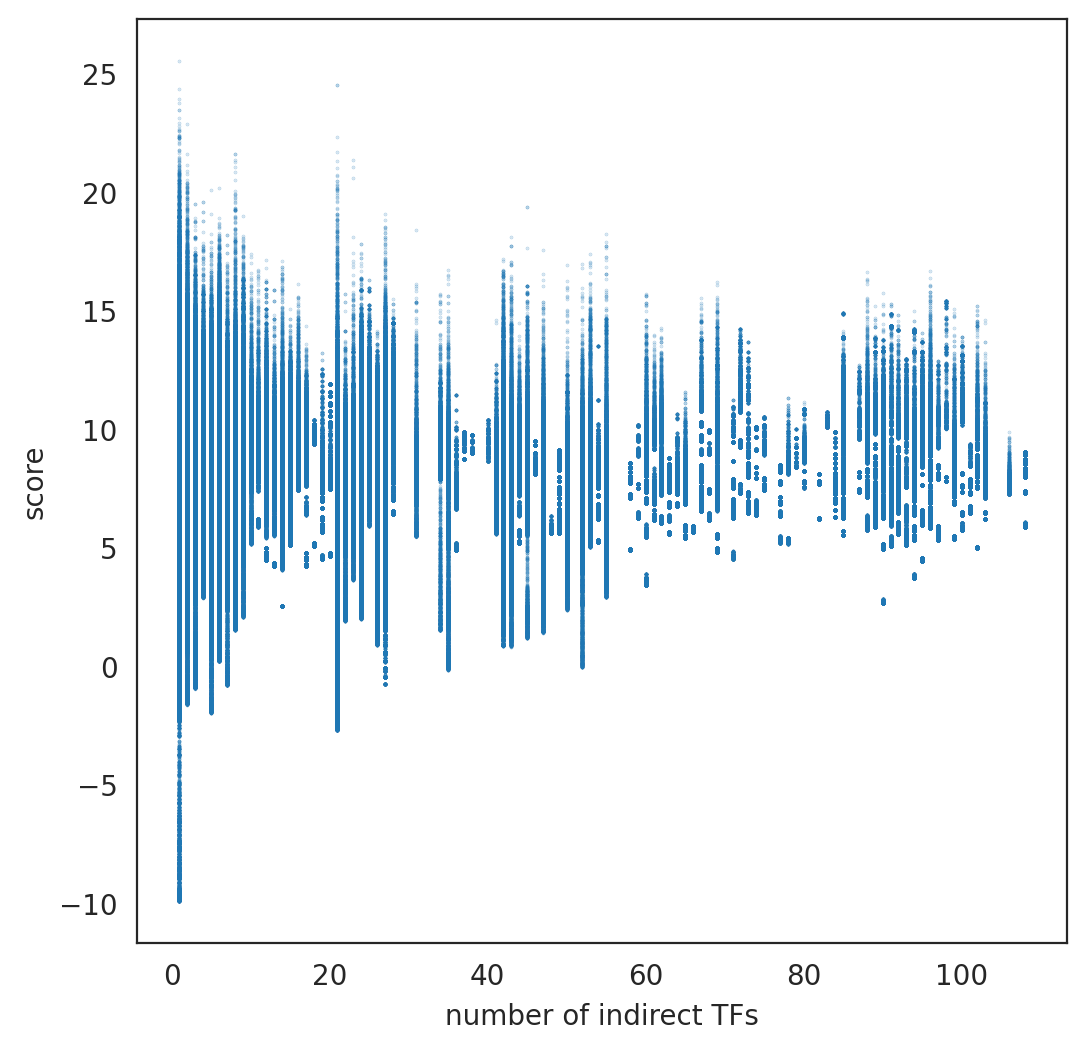

In [124]:
# A scatter plot for 
plt.scatter(data = tfi.scanned_df, 
                x="n_indirect", 
                y="score", alpha=0.3, s=0.1)
plt.xlabel("number of indirect TFs")
plt.ylabel("score")

<AxesSubplot:xlabel='n_indirect', ylabel='Count'>

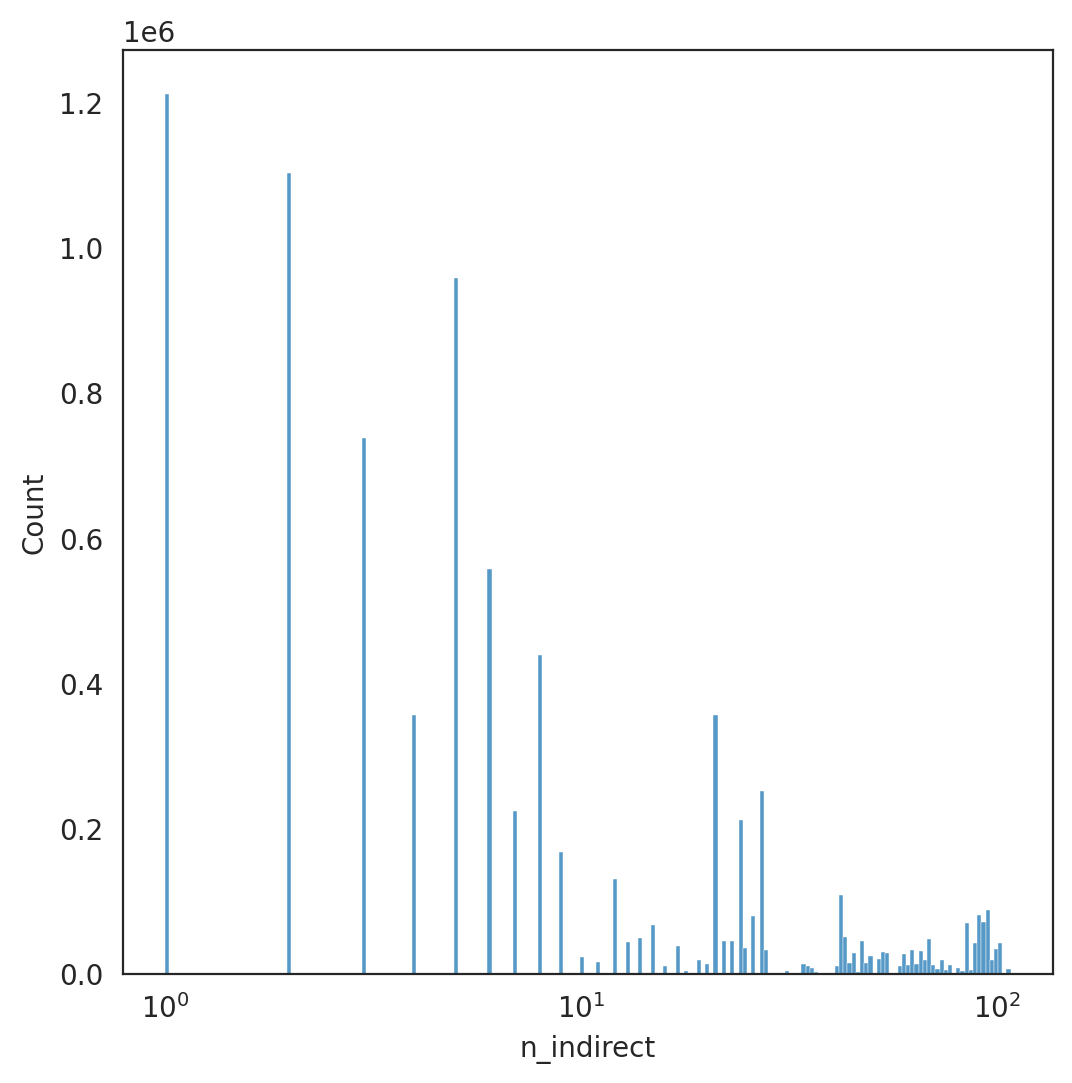

In [122]:
# histogram for the number of indirect TFs
sns.histplot(tfi.scanned_df['n_indirect'], log_scale=(True, False)) 
#plt.xscale("log")


In [125]:
tfi.scanned_df['factors_direct'].value_counts() 

factors_direct
                   8319070
myrf                  5653
prkrira               4051
prkrirb               2841
A6H8I1_DANRE          2597
kdm2aa                2582
kdm2ba                2571
si:dkey-43p13.5       1940
pax2b                 1896
dharma                1602
arid6                 1426
pou3f3b               1197
nr2f2                 1021
hsf2                   785
vsx2                   619
Name: count, dtype: int64

In [126]:
peak_counts = pd.DataFrame(tfi.scanned_df.groupby(['seqname','motif_id']).size() )
peak_counts.reset_index(inplace = True)

#peak_counts = peak_counts[peak_counts['factors_direct']!=""]
peak_counts.rename(columns= {0:'hits'},inplace = True)
peak_counts.sort_values('hits',ascending = False)

,seqname,motif_id,hits
4881896,chr3_8510144_8511311,M08340_2.00,100
1669492,chr16_54405533_54406449,M08340_2.00,100
4162472,chr25_37489624_37490462,M08340_2.00,99
1669422,chr16_54405533_54406449,M04839_2.00,96
6389857,chr8_49431463_49432325,M00262_2.00,88
...,...,...,...
2475592,chr1_135732_136599,M03397_2.00,1
2475590,chr1_135732_136599,M03330_2.00,1
2475588,chr1_135732_136599,M03325_2.00,1
2475587,chr1_135732_136599,M03324_2.00,1


Let's look at the length distribution 

Text(0, 0.5, 'occurrences')

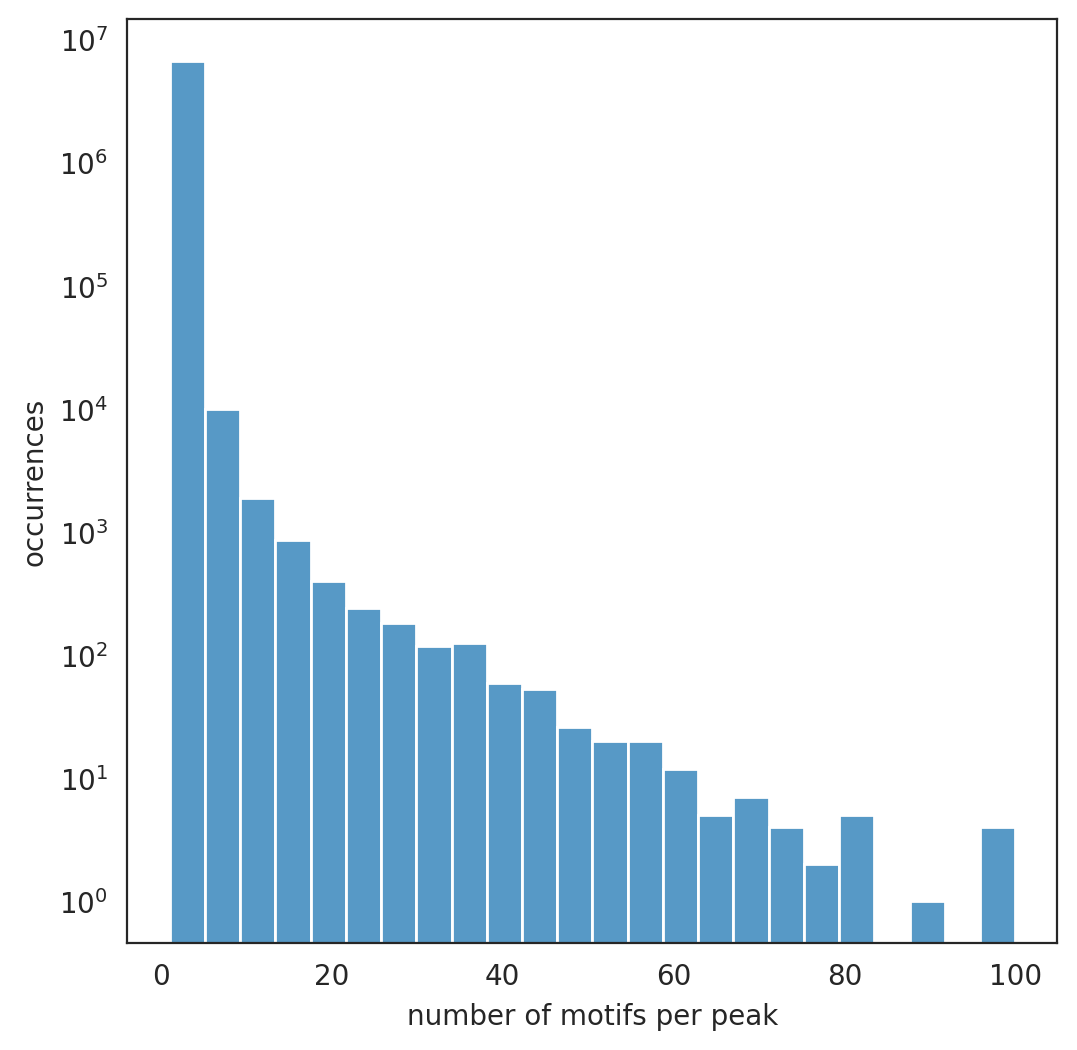

In [130]:
sns.histplot(peak_counts.hits)
plt.yscale("log")
plt.xlabel("number of motifs per peak")
plt.ylabel("occurrences")

In [131]:
len(set(tfi.scanned_df.motif_id))

4897

In [132]:
len(set(tfi.scanned_df.seqname))

13936

In [133]:
tfi.scanned_df.seqname.value_counts() 

seqname
chr25_3326547_3327457      1628
chr5_1047106_1047959       1627
chr22_195121_195993        1617
chr5_37087047_37087934     1590
chr1_171543_172374         1539
                           ... 
chr5_4493387_4493856         96
chr3_46379325_46379660       94
chr6_13095987_13096350       83
chr24_7699894_7700148        74
chr17_48946883_48947136      67
Name: count, Length: 13936, dtype: int64

### Question:
- Q. what is the difference between "factors_direct" and "factors_indirect"? inference from the same species vs related species? or is there a score?
- Q. How is the "score" in tfi.scanned_df is computed? A: The "score" is a numerical value that indicates how well the predicted motif matches the DNA sequence at a given genomic location.
- 

We have the score for each sequence and motif_id pair.
In the next step we will filter the motifs with low scores.

Question: What is the "motif_id"? Is it a unique id for each "peak"? or is it an ID for TF?

# 4. Filtering motifs

<AxesSubplot:>

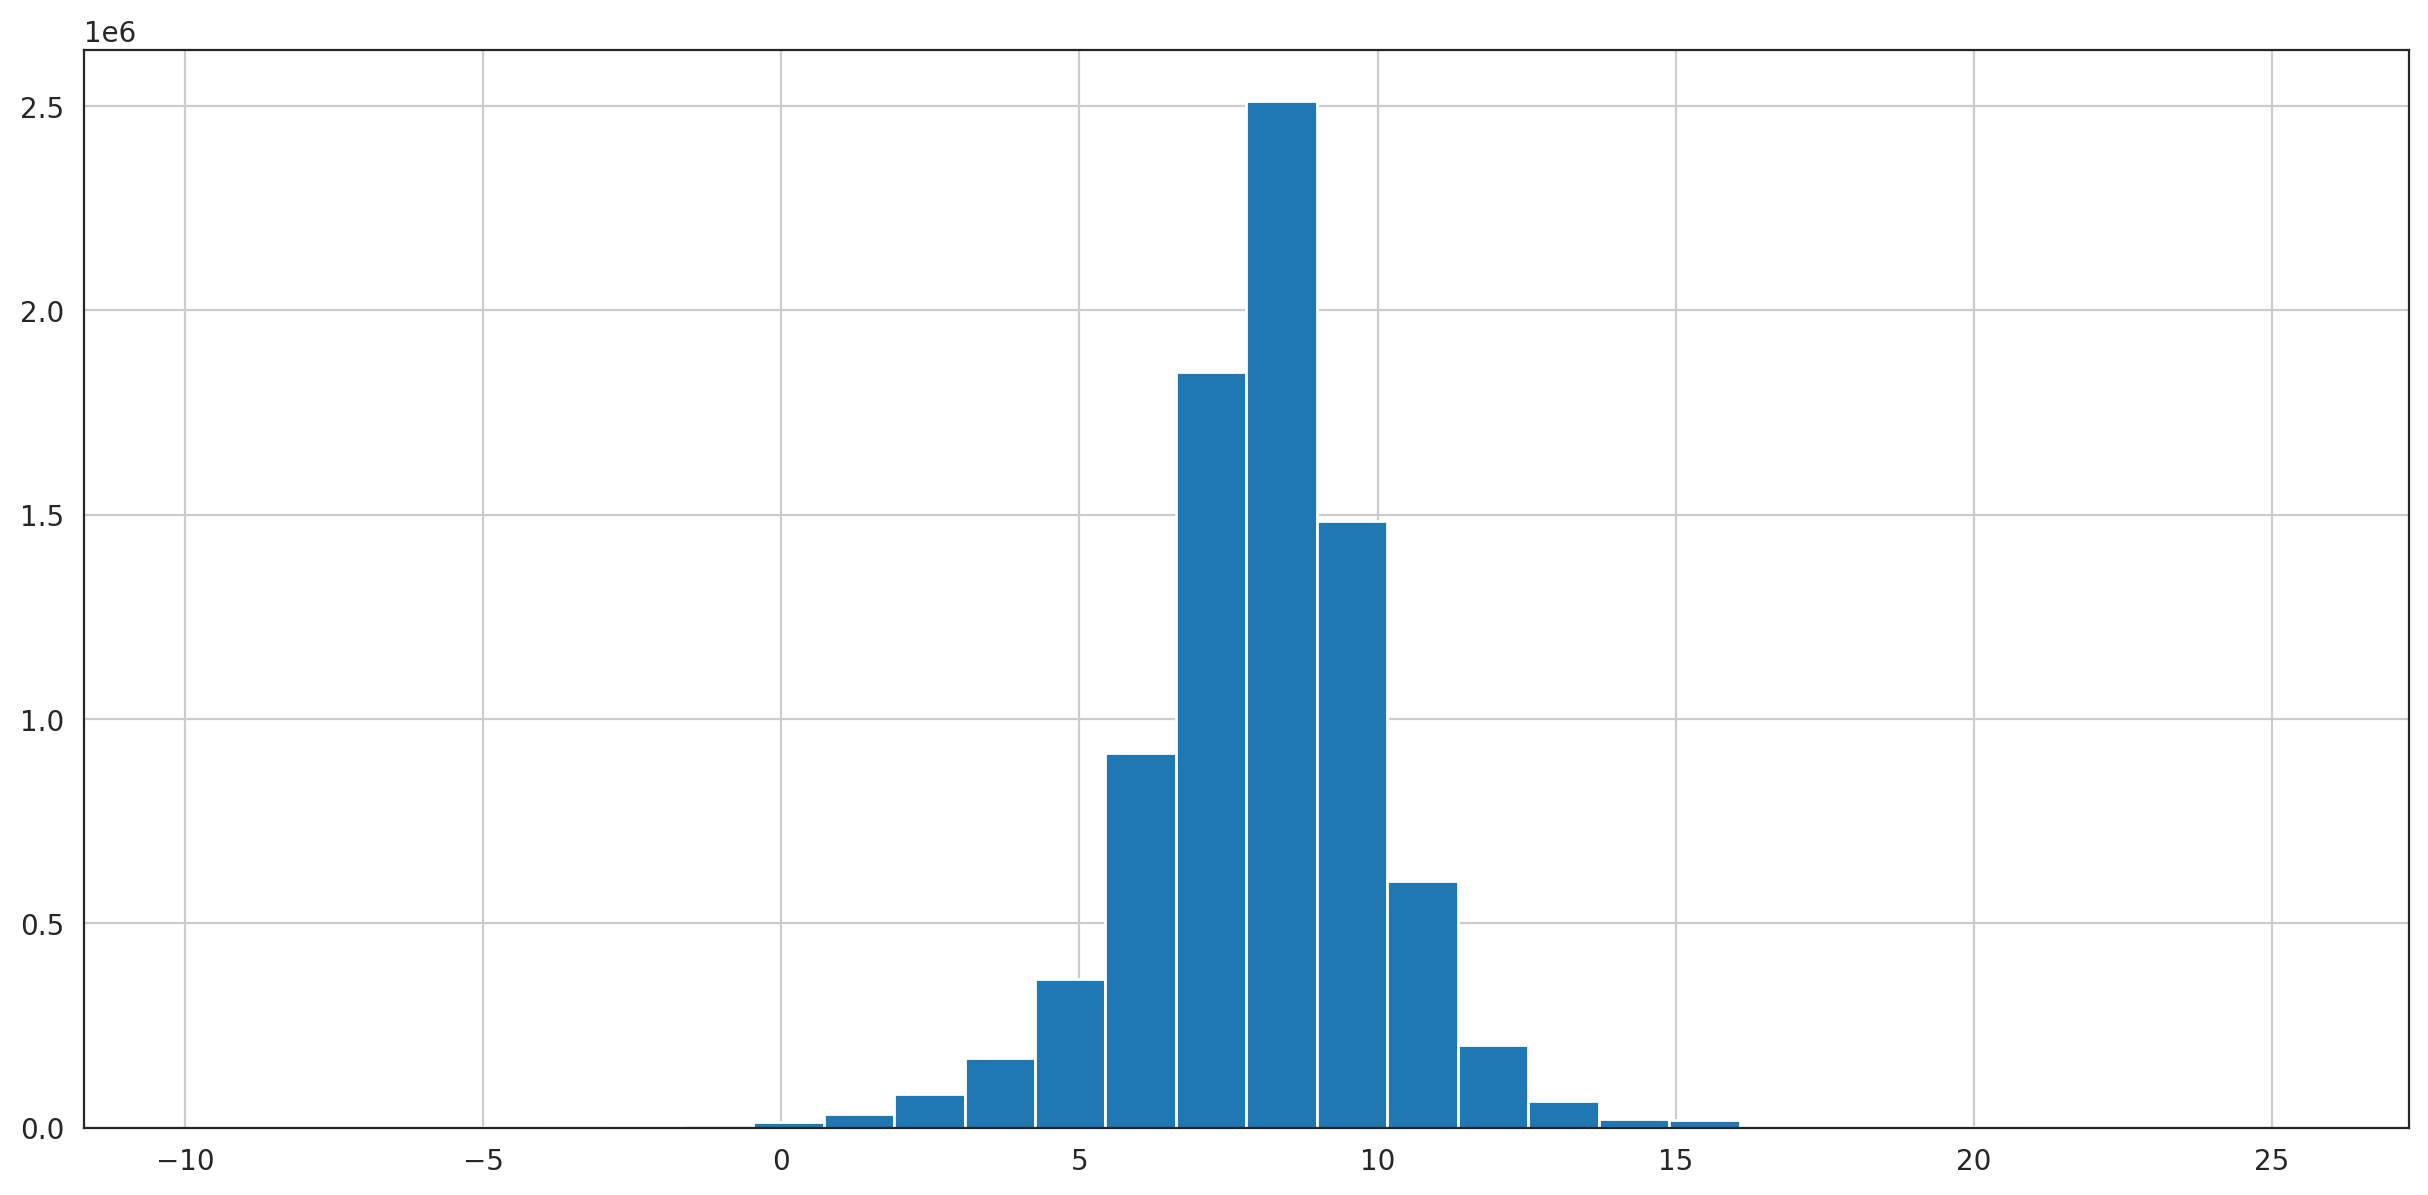

In [32]:
tfi.scanned_df["score"].hist(bins=30)

In [134]:
# Reset filtering 
tfi.reset_filtering()

# Do filtering
tfi.filter_motifs_by_score(threshold=10)

# Format post-filtering results.
tfi.make_TFinfo_dataframe_and_dictionary(verbose=True)



Filtering finished: 8349851 -> 1882939
1. Converting scanned results into one-hot encoded dataframe.


  0%|          | 0/13936 [00:00<?, ?it/s]

2. Converting results into dictionaries.


  0%|          | 0/12674 [00:00<?, ?it/s]

  0%|          | 0/867 [00:00<?, ?it/s]

# 5. Get final base GRN

## 5.1. Get results as a dataframe

In [137]:
df = tfi.to_dataframe()
df.head()

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
0,chr10_10310135_10311044,mir219-1,0,0,1,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
1,chr10_10312654_10313520,urm1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr10_10318857_10319768,mir219-1,0,0,1,1,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
3,chr10_10330150_10331040,mir219-1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr10_10728430_10729439,swi5,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [136]:
len(df)

14511

In [147]:
# Just to check, how many genes were duplicated in the dataframe (peaks(motifs)-by-TFs)
df_multiple_peaks_per_genes = df[df.duplicated("gene_short_name")]
df_multiple_peaks_per_genes

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
2,chr10_10318857_10319768,mir219-1,0,0,1,1,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
3,chr10_10330150_10331040,mir219-1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
13,chr10_11265074_11265871,hsdl2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,chr10_11841215_11841842,trim23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,chr10_13178403_13179394,musk,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14468,chr9_69838_70704,il10rb,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14478,chr9_7365654_7366518,ihha,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
14484,chr9_7612035_7612953,mir153c,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14486,chr9_7656132_7656759,dnajb2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
df_multiple_peaks_per_genes.value_counts("gene_short_name")

gene_short_name
myf5         9
her1         7
mir196a-1    7
hoxb3a       6
tbx16        6
            ..
hoxa13b      1
hoxa13a      1
hnrnpr       1
hnrnpdl      1
zswim8       1
Name: count, Length: 1658, dtype: int64

In [151]:
df_multiple_peaks_per_genes[df_multiple_peaks_per_genes["gene_short_name"]=="myf5"]

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
10761,chr4_21660593_21661497,myf5,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10762,chr4_21694264_21695059,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10763,chr4_21696596_21697063,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10764,chr4_21724146_21724976,myf5,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10765,chr4_21736676_21737587,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10766,chr4_21738624_21739481,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10767,chr4_21740822_21741654,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10768,chr4_21744914_21745703,myf5,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10769,chr4_21745860_21746718,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
len(df.gene_short_name.unique())

3135

# 6. Save results
We will use this information when constructing the GRN models later. Save the results.

In [152]:
# Save result as a dataframe
df = tfi.to_dataframe()
df.to_parquet(cicero_output_path + "05_TDR118_base_GRN_dataframe.parquet")


In [153]:
cicero_output_path

'/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/'

**We will use this base GRN data in the GRN construction section.**

https://morris-lab.github.io/CellOracle.documentation/tutorials/networkanalysis.html